In [1]:
!pip install tensorflow tf2onnx onnxruntime numpy


  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.12.2
    Uninstalling typing-extensions-4.12.2:
      Successfully uninstalled typing-extensions-4.12.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0 requires torch==1.11.0, but you have torch 2.0.1+cu117 which is incompatible.
emoji 2.13.0 requires typing-extensions>=4.7.0, but you have typing-extensions 4.5.0 which is incompatible.
altair 5.4.1 requires typing-extensions>=4.10.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.


In [7]:
import tensorflow as tf
import tf2onnx
import numpy as np
import onnx
import onnxruntime as ort
import time
import matplotlib.pyplot as plt

# Step 1: Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the images

# Reshape data to add a channel dimension
x_train = x_train[..., np.newaxis].astype("float32")
x_test = x_test[..., np.newaxis].astype("float32")

# Step 2: Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test))  # Train for 1 epoch for demo purposes

# Step 3: Convert the model to ONNX format
onnx_model_path = "mnist_cnn_model.onnx"
spec = (tf.TensorSpec((None, 28, 28, 1), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=onnx_model_path)
print(f"Model exported to {onnx_model_path}")

# Step 4: Load and validate the ONNX model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid")

# Step 5: Set up ONNX Runtime session
ort_session = ort.InferenceSession(onnx_model_path)

tf.config.run_functions_eagerly(True)



1875/1875 [==============================] - 221s 118ms/step - loss: 0.1373 - accuracy: 0.9573 - val_loss: 0.0360 - val_accuracy: 0.9881
Model exported to mnist_cnn_model.onnx
ONNX model is valid


1/1 [==============================] - 0s 31ms/step


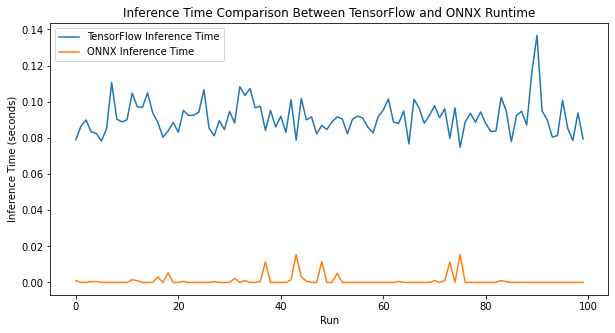

In [10]:






# Step 8: Measure and plot inference time for TensorFlow and ONNX models
def measure_inference_time(tf_model, ort_session, x_test, num_runs=100):
    tf_times = []
    onnx_times = []

    for _ in range(num_runs):
        # Select a single random sample image and ensure correct shape for the model
        test_image = np.expand_dims(x_test[np.random.randint(len(x_test))], axis=0)

        # TensorFlow inference time
        start_time = time.time()
        tf_output = tf_model.predict(test_image)
        tf_times.append(time.time() - start_time)

        # ONNX inference time
        start_time = time.time()
        onnx_output = ort_session.run(None, {'input': test_image.astype(np.float32)})
        onnx_times.append(time.time() - start_time)

    return tf_times, onnx_times

# Run inference timing
tf_times, onnx_times = measure_inference_time(tf_model, ort_session, x_test)

# Step 9: Plot the inference time comparison
plt.figure(figsize=(10, 5))
plt.plot(tf_times, label="TensorFlow Inference Time")
plt.plot(onnx_times, label="ONNX Inference Time")
plt.xlabel("Run")
plt.ylabel("Inference Time (seconds)")
plt.legend()
plt.title("Inference Time Comparison Between TensorFlow and ONNX Runtime")
plt.show()


In [11]:
pip install onnx2pytorch


  Using cached torch-1.11.0-cp38-cp38-win_amd64.whl (158.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu117
    Uninstalling torch-2.0.1+cu117:
      Successfully uninstalled torch-2.0.1+cu117
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Import necessary libraries
import onnx
import torch
import numpy as np
from onnx2pytorch import ConvertModel

# Step 1: Load the ONNX model
onnx_model_path = "mnist_cnn_model.onnx"  # Update this path if your model has a different name
onnx_model = onnx.load(onnx_model_path)

# Step 2: Convert the ONNX model to a PyTorch model
pytorch_model = ConvertModel(onnx_model)

# Step 3: Prepare sample input (similar to the original input shape)
# For the MNIST dataset, the input should be in the shape (batch_size, 1, 28, 28)
sample_input = np.random.rand(1, 1, 28, 28).astype(np.float32)  # Replace with actual test data as needed
sample_input_tensor = torch.tensor(sample_input)

# Step 4: Run inference on the PyTorch model
with torch.no_grad():  # No need to calculate gradients during inference
    output = pytorch_model(sample_input_tensor)

# Step 5: Process and display the output
print("PyTorch model output:", output)


PyTorch model output: tensor([[0.0699, 0.0730, 0.1236, 0.1025, 0.0771, 0.1461, 0.0522, 0.0757, 0.2124,
         0.0674]])


C:\Users\karthi\anaconda3\envs\object\lib\site-packages\onnx2pytorch\convert\layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))
C:\Users\karthi\anaconda3\envs\object\lib\site-packages\torch\nn\functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
